In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
df = pd.read_csv('Reviews.csv')

In [5]:
df.shape

(568454, 10)

In [6]:
df = df.head(1000)

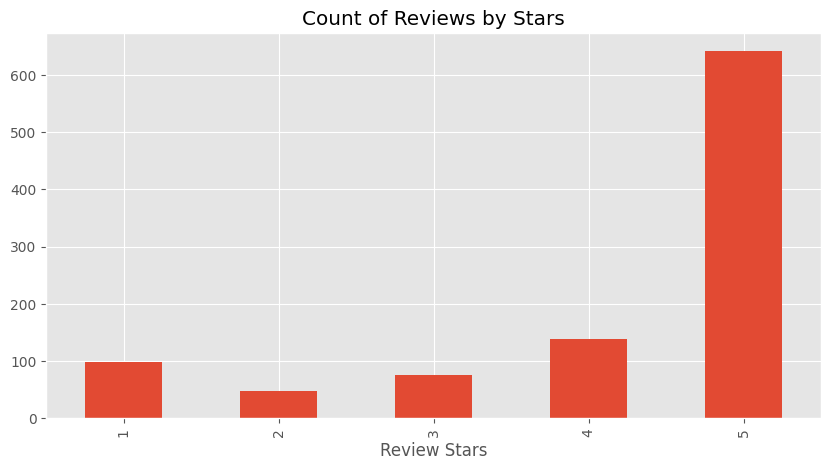

In [7]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [10]:
example = df['Text'][500]
example

"I bought these for the office and no one can put them down. I'm ordering more today and it has only been 2 weeks. Didn't have to shop for them either, Amazon brought it to my door!"

In [11]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'bought', 'these', 'for', 'the', 'office', 'and', 'no', 'one', 'can']

In [12]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('bought', 'VBD'),
 ('these', 'DT'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('office', 'NN'),
 ('and', 'CC'),
 ('no', 'DT'),
 ('one', 'NN'),
 ('can', 'MD')]

In [13]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  bought/VBD
  these/DT
  for/IN
  the/DT
  office/NN
  and/CC
  no/DT
  one/NN
  can/MD
  put/VB
  them/PRP
  down/RP
  ./.
  I/PRP
  'm/VBP
  ordering/VBG
  more/JJR
  today/NN
  and/CC
  it/PRP
  has/VBZ
  only/RB
  been/VBN
  2/CD
  weeks/NNS
  ./.
  Did/VBP
  n't/RB
  have/VB
  to/TO
  shop/VB
  for/IN
  them/PRP
  either/DT
  ,/,
  (PERSON Amazon/NNP)
  brought/VBD
  it/PRP
  to/TO
  my/PRP$
  door/NN
  !/.)


In [ ]:
# VADER Sentiment Scoring

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores('I am very very happy!')

{'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'compound': 0.6771}

In [16]:
sia.polarity_scores('This is worst case. I do not like it')

{'neg': 0.509, 'neu': 0.491, 'pos': 0.0, 'compound': -0.7359}

In [17]:
sia.polarity_scores(example)

{'neg': 0.067, 'neu': 0.887, 'pos': 0.046, 'compound': -0.2003}

In [18]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [20]:
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


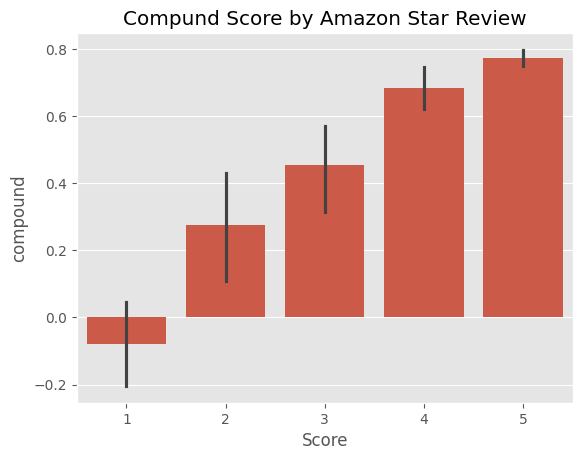

In [21]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

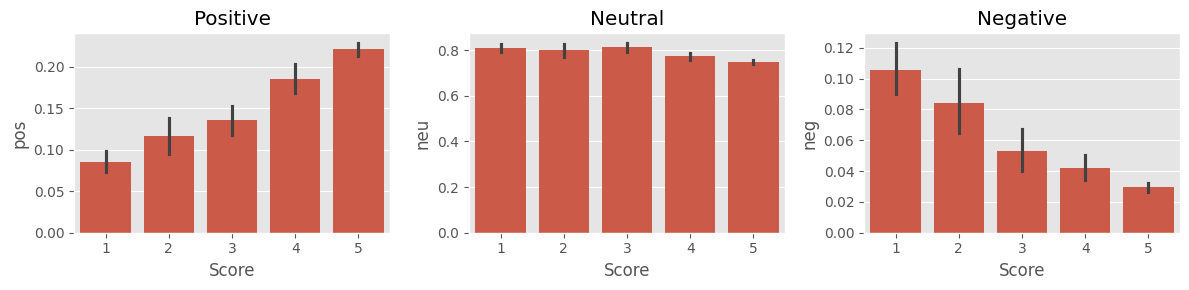

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [24]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Users\presh\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\presh\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.
